In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  8 15:08:44 2022

@author: Wenhao Hsu
"""
from rdkit.Chem import AllChem
from rdkit import Chem
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def get_fp_mat( SMILES_list, r = 2, nBits =2048,func = AllChem.GetMorganFingerprintAsBitVect):
    """
    do: generate the morgan-fingerprints and save it as matrix
    SMILES_list: The list of SMILES string
    OUTPUT: morgan-fingerprints matrix
    """
    fps = []
    for SMILES_string in SMILES_list:
        mol = Chem.MolFromSmiles(SMILES_string)
        if func == AllChem.GetMorganFingerprintAsBitVect:
            fp = func(mol,r,useFeatures=False, nBits=nBits).ToBitString()
            fps.append(fp)
        elif func == Chem.RDKFingerprint:
            fp = func(mol = mol,maxPath = r, fpSize=nBits).ToBitString()
            fps.append(fp)
    bits = []
    for fp in fps:
        bit_list = []
        for bit in fp:
            bit_list.append( int(bit) )
        bits.append(bit_list)
    return bits

In [3]:
# get data set from filepath and do the data cleaning
dataset_path = './data/csv/washed_data_train.csv'
df = pd.read_csv(dataset_path)
df = df.dropna(subset=['lambda_onset'])
df = df.dropna(subset=['Non_fixed?'])
df = df.reset_index(drop=True)
print('\nImported data from '+ dataset_path+', shape: '+str(np.shape(df)))


Imported data from ./data/csv/washed_data_train.csv, shape: (246, 46)


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

In [5]:
import sys
import os
def clear_output():
    """
    clear output for both jupyter notebook and the console
    """
    os.system('cls' if os.name == 'nt' else 'clear')
    if 'ipykernel' in sys.modules:
        from IPython.display import clear_output as clear
        clear()

In [6]:
from sklearn.metrics import mean_absolute_percentage_error
pd.set_option('display.float_format',lambda x : '%.3f' % x) # Disable scientific counting
np.set_printoptions(suppress=True) 
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
models=[KNeighborsRegressor(),Ridge(),Lasso()]
models_str=['KNNRegressor','Ridge','Lasso']
model_config = {'KNNRegressor':Chem.RDKFingerprint,'Ridge':Chem.RDKFingerprint,'Lasso':AllChem.GetMorganFingerprintAsBitVect}
ss_config = {'KNNRegressor':1,'Ridge':0,'Lasso':1}


In [7]:
for model,model_name in zip(models,models_str):
    score_table = pd.DataFrame(index = range(512,5632,512),columns = range(1,11))
    MAPE_table   = pd.DataFrame(index = range(512,5632,512),columns = range(1,11))
    for nBits in range(512,5632,512):
        for i in range(1,11):
            clear_output()
            print('Starting...\n'+model_name+' '+str(i)+' '+str(nBits)+'\nss_config: '+str(ss_config[model_name])+'\n--> ./data/csv/nbits+radii_score_'+model_name+'.csv')
            x = pd.DataFrame(get_fp_mat(df['SMILES'],r = i,nBits = nBits,func=model_config[model_name]))
            x['Mol.wt'] = df['Mol.wt']
            x['Non_fixed?'] = df['Non_fixed?']
            y = pd.DataFrame(df['lambda_onset']) 
            x_train, x_test, y_train, y_test = train_test_split( x, y,test_size=0.2,random_state=2022)
            y_train = np.ravel(y_train)
            if ss_config[model_name] == 0:
                x_train = x_train.reset_index(drop=True)
            elif ss_config[model_name] == 1:
                x_train = ss.fit_transform(x_train)
                x_test = ss.fit_transform(x_test)
            model.fit(x_train,y_train)
            y_pred=model.predict(x_test)
            score=model.score(x_test,np.ravel(y_test))
            MAPE = mean_absolute_percentage_error(y_pred, y_test)
            score_table.loc[nBits,i] = score
            MAPE_table.loc[nBits,i] = MAPE
            print(score,MAPE)
            print('Done '+str(i)+'/10')
    score_table.to_csv('./data/csv/nbits+radii_score_'+model_name+'.csv')
    MAPE_table.to_csv('./data/csv/nbits+radii_MAPE_'+model_name+'.csv')


Starting...
Lasso 10 5120
ss_config: 1
--> ./data/csv/nbits+radii_score_Lasso.csv
0.4460884236825138 0.05123129671472583
Done 10/10


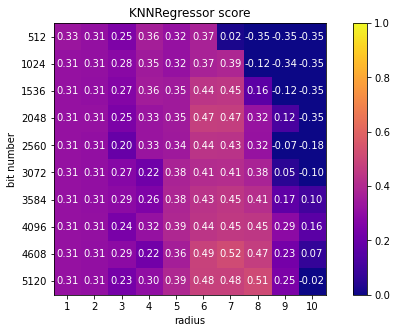

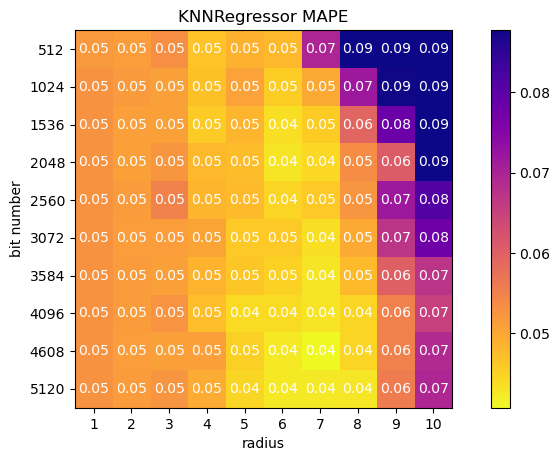

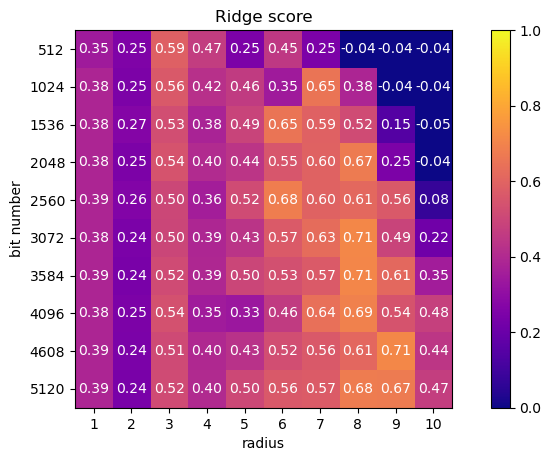

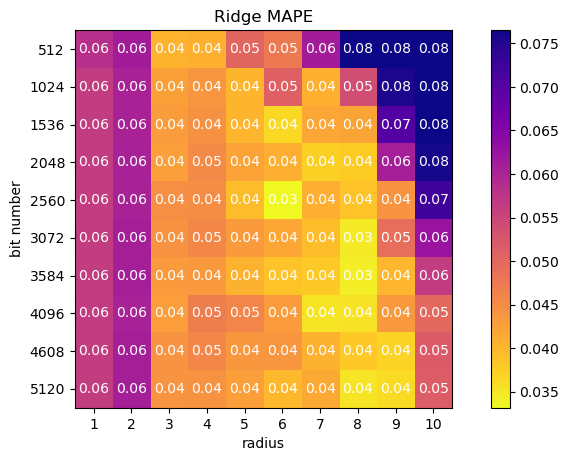

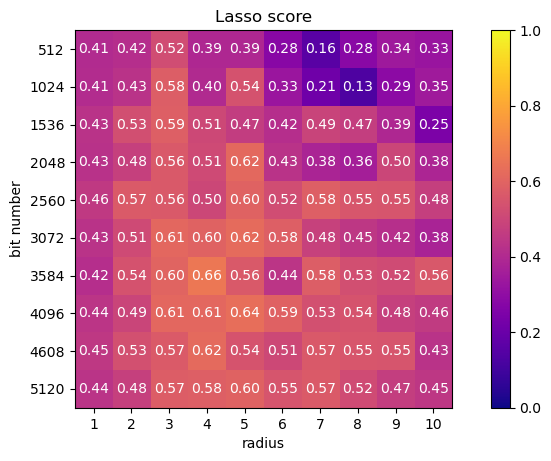

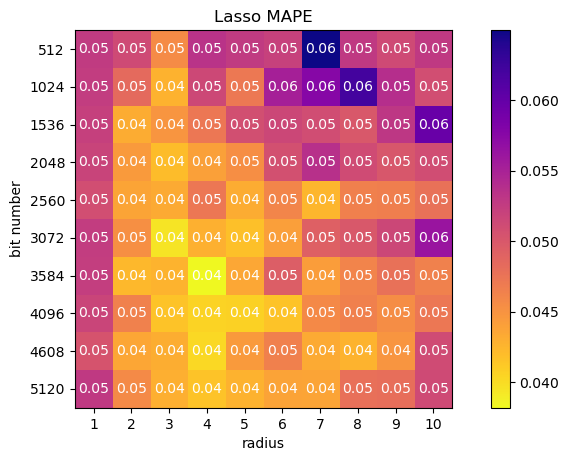

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import MultipleLocator

for model_name in models_str:
    plt.rcParams['savefig.dpi'] = 200 #图片像素
    plt.rcParams['figure.dpi'] = 100 #分辨率
    plt.figure(figsize=(10,5)) #设置画布的尺寸
    score_table = pd.read_csv('./data/csv/nbits+radii_score_'+model_name+'.csv',index_col=0)
    score_table_mat = np.array(score_table, dtype=float)
    plt.title(model_name+' score')
    ax=plt.gca()
    plt.colorbar(plt.imshow(score_table_mat,cmap='plasma',vmin=0,vmax=1))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_yticklabels(np.arange(512,5632,512))
    ax.set_xticklabels(np.arange(0, 11, 1))
    plt.xlabel("radius")
    plt.ylabel("bit number")
    for (x, y), value in np.ndenumerate(score_table_mat.T):
        plt.text(x, y, f"{value:.2f}",color = 'w', va="center", ha="center")
    plt.show()

    plt.rcParams['savefig.dpi'] = 200 #图片像素
    plt.rcParams['figure.dpi'] = 100 #分辨率
    plt.figure(figsize=(10,5)) #设置画布的尺寸
    MAPE_table = pd.read_csv('./data/csv/nbits+radii_MAPE_'+model_name+'.csv',index_col=0)
    MAPE_table_mat = np.array(MAPE_table, dtype=float)
    plt.title(model_name+" MAPE")
    ax=plt.gca()
    plt.colorbar(plt.imshow(MAPE_table_mat,cmap='plasma_r'))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_yticklabels(np.arange(512,5632,512))
    ax.set_xticklabels(np.arange(0, 11, 1))
    plt.xlabel("radius")
    plt.ylabel("bit number")
    for (x, y), value in np.ndenumerate(MAPE_table_mat.T):
        plt.text(x, y, f"{value:.2f}",color = 'w', va="center", ha="center")
    plt.show()

In [9]:

model = KNeighborsRegressor()
model_name = 'KNNRegressor'

# clear_output()
x = pd.DataFrame(get_fp_mat(df['SMILES'],r = 1,nBits = 512,func=model_config[model_name]))
x['Mol.wt'] = df['Mol.wt']
x['Non_fixed?'] = df['Non_fixed?']
y = pd.DataFrame(df['lambda_onset']) 
x_train, x_test, y_train, y_test = train_test_split( x, y,test_size=0.2,random_state=2022)
y_train = np.ravel(y_train)
if ss_config[model_name] == 0:
    x_train = x_train.reset_index(drop=True)
elif ss_config[model_name] == 1:
    x_train = ss.fit_transform(x_train)
    x_test = ss.fit_transform(x_test)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=model.score(x_test,np.ravel(y_test))
MAPE = mean_absolute_percentage_error(y_pred, y_test)
score_table.loc[nBits,i] = score
MAPE_table.loc[nBits,i] = MAPE
print(score,MAPE)
print('Done '+str(i)+'/10')


0.330351612953109 0.051864346557386254
Done 10/10


In [10]:
model = Lasso()
model_name = 'lasso'
ss_conf = 0
# clear_output()
x = pd.DataFrame(get_fp_mat(df['SMILES'],r = 3,nBits = 1536,func=AllChem.GetMorganFingerprintAsBitVect))
y = pd.DataFrame(df['λPL/nm']) 
x_train, x_test, y_train, y_test = train_test_split( x, y,test_size=0.2,random_state=2022)
y_train = np.ravel(y_train)
if ss_conf == 0:
    x_train = x_train.reset_index(drop=True)
elif ss_conf == 1:
    x_train = ss.fit_transform(x_train)
    x_test = ss.fit_transform(x_test)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=model.score(x_test,np.ravel(y_test))
MAPE = mean_absolute_percentage_error(y_pred, y_test)
score_table.loc[nBits,i] = score
MAPE_table.loc[nBits,i] = MAPE
print(score,MAPE)
print('Done '+str(i)+'/10')

KeyError: 'λPL/nm'